# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
from scipy import datasets, ndimage
import numpy as np
import matplotlib.pyplot as plt

# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

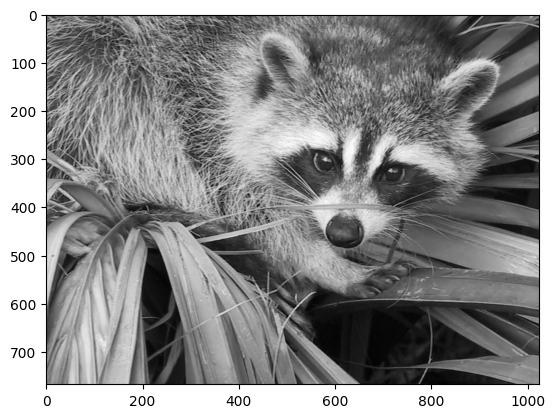

In [2]:
X = datasets.face(gray=True)
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata Fourier a unei imagini

Transformata Fourier Discretă se extinde ușor la mai multe dimensiuni. Pentru un semnal bidimensional precum o imagine DFT devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}\sum_{n_2=0}^{N_2-1}x_{n_1,n_2}e^{-j2\pi(m_1 n_1/N_1 + m_2 n_2/N_2)}
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric
* proprietățile transformatei DFT 1D sunt respectate și în cazul celei 2D

În continuare vom folosi rutina generală `fft2` ce servește mai bine activității de învățare, deși pentru semnale reale ar trebui să folosim `rfft2` ce întoarce doar informația esențială (ex. omite simetriile). De asemenea vom analiza spectrul în scală logaritmică pentru a diferenția mai bine magnitudinile bin-urilor DTF.

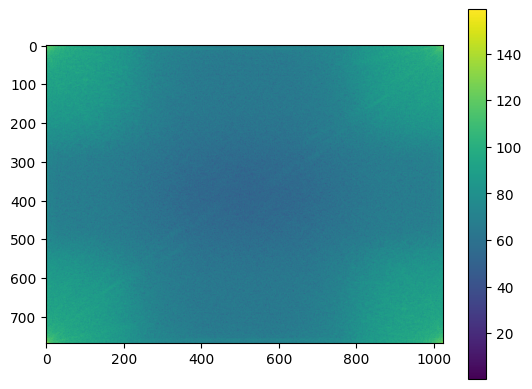

In [3]:
Y = np.fft.fft2(X)
freq_db = 20*np.log10(abs(Y))

plt.imshow(freq_db)
plt.colorbar()
plt.show()

Operațiile efectuate direct asupra imaginii se reflectă și în spectrul acesteia. Iată un exemplu a unei rotații de 45 de grade:

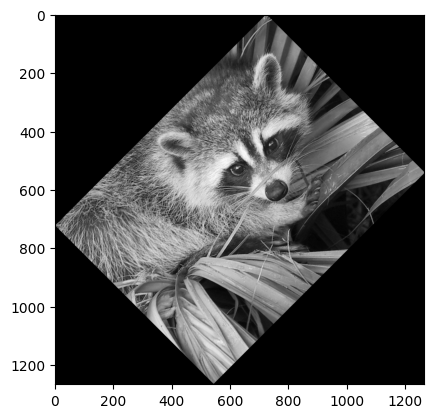

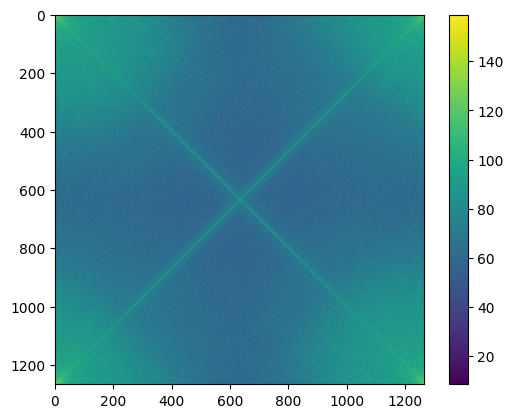

In [4]:
rotate_angle = 45
X45 = ndimage.rotate(X, rotate_angle)
plt.imshow(X45, cmap=plt.cm.gray)
plt.show()

Y45 = np.fft.fft2(X45)
plt.imshow(20*np.log10(abs(Y45)))
plt.colorbar()
plt.show()

Momentan pe axe sunt afișate numărul bin-urilor. Pentru a obține frecvențele asociate folosiți `fftfreq`:

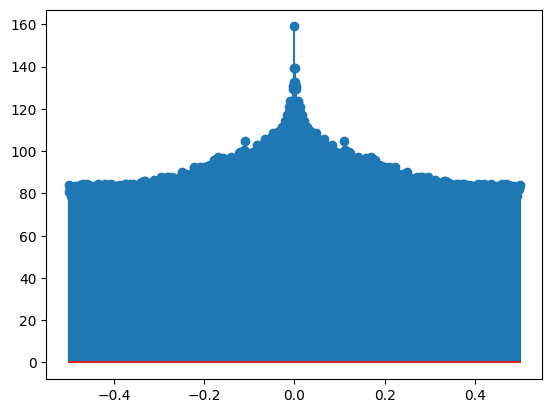

In [5]:
freq_x = np.fft.fftfreq(X.shape[1])
freq_y = np.fft.fftfreq(X.shape[0])

plt.stem(freq_x, freq_db[:][0])
plt.show()

# Atenuarea frecvențelor înalte

Pentru a anula frecvențele de peste un anumit prag `freq_cutoff` putem pur și simplu anula intrările din spectru și aplica transformata Fourier inversă:

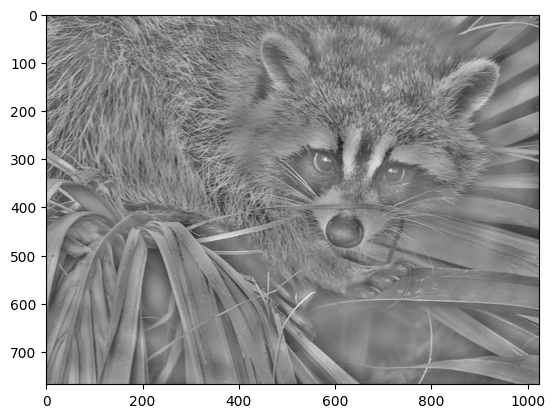

In [6]:
freq_cutoff = 120

Y_cutoff = Y.copy()
Y_cutoff[freq_db > freq_cutoff] = 0
X_cutoff = np.fft.ifft2(Y_cutoff)
X_cutoff = np.real(X_cutoff)    # avoid rounding erros in the complex domain,
                                # in practice use irfft2
plt.imshow(X_cutoff, cmap=plt.cm.gray)
plt.show()

# Zgomot

Zgomotul alb perturbă în mod egal spectrul semnalului. Este astfel egal distribuit și regăsit în toate bin-urile DFT. [Zgomotul color](https://en.wikipedia.org/wiki/Colors_of_noise) se schimbă de-a lungul frecvențelor.

Putem adăuga zgomot în limita a `pixel_noise` pixeli imaginii folosind `random.randint`:

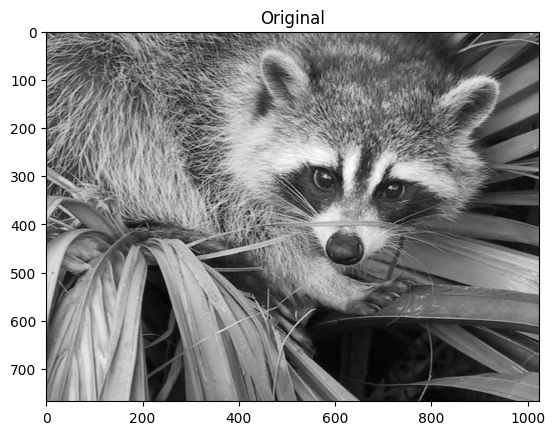

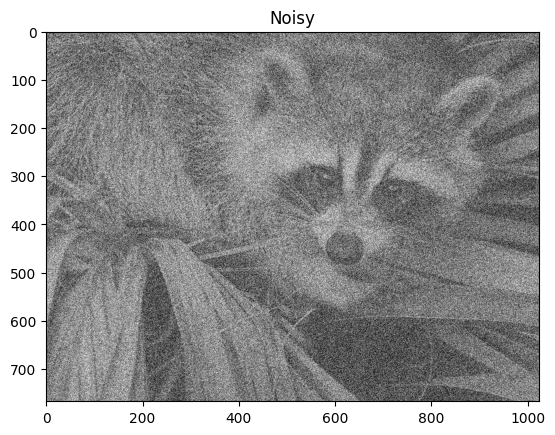

In [7]:
pixel_noise = 200

noise = np.random.randint(-pixel_noise, high=pixel_noise+1, size=X.shape)
X_noisy = X + noise
plt.imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.show()
plt.imshow(X_noisy, cmap=plt.cm.gray)
plt.title('Noisy')
plt.show()

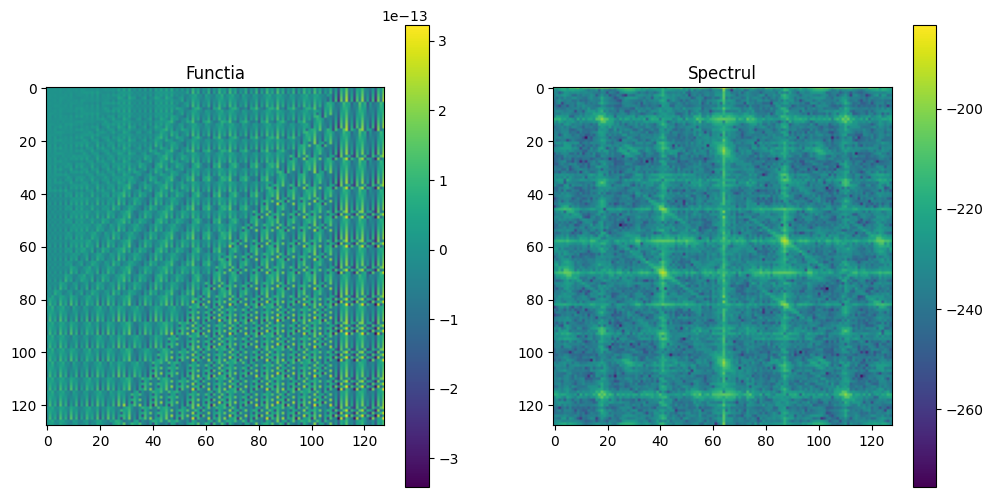

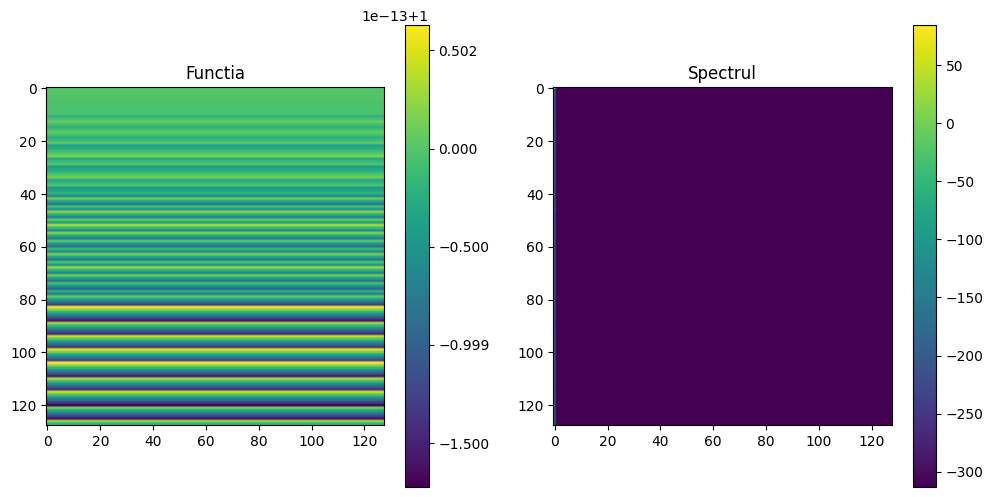

In [15]:
n1, n2 = 128, 128
def plot_image_and_spectrum(X=None, Y=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    if Y is None:
        Y = 20 * np.log10(abs(np.fft.fft2(X)) + np.finfo(np.float64).eps)
    elif X is None:
        X = np.fft.ifft2(Y)

    axs[1].imshow(Y), axs[1].set_title("Spectrul")
    fig.colorbar(axs[1].imshow(Y), ax=axs[1])
    axs[0].imshow(np.real(X)), axs[0].set_title("Functia")
    fig.colorbar(axs[0].imshow(np.real(X)), ax=axs[0])

    plt.show()


def plot_signal(func):
    i, j = np.indices((n1, n2))
    x = func(i, j)
    plot_image_and_spectrum(X=x)


func1 = lambda i, j: np.sin(2 * np.pi * i + 3 * np.pi * j)
func2 = lambda i, j: np.sin(4 * np.pi * i) + np.cos(6 * np.pi * j)
plot_signal(func1)
plot_signal(func2)
# Floating point errors 

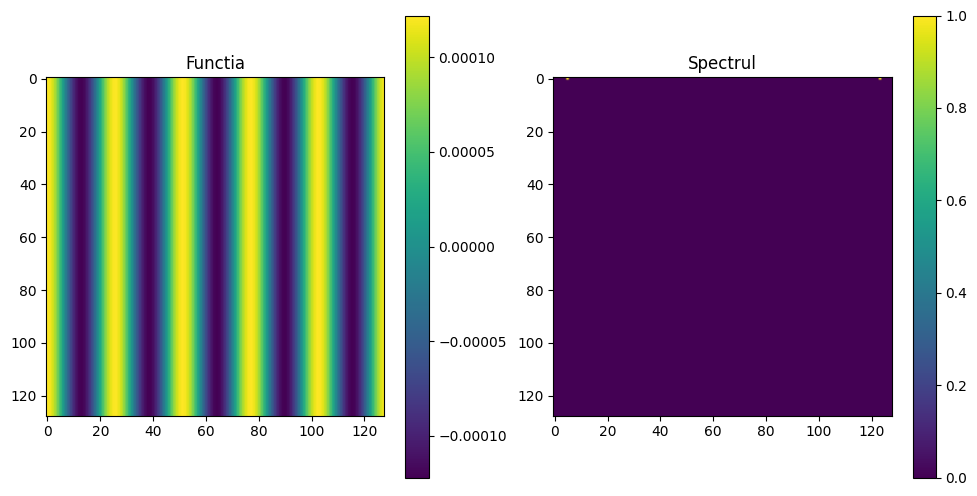

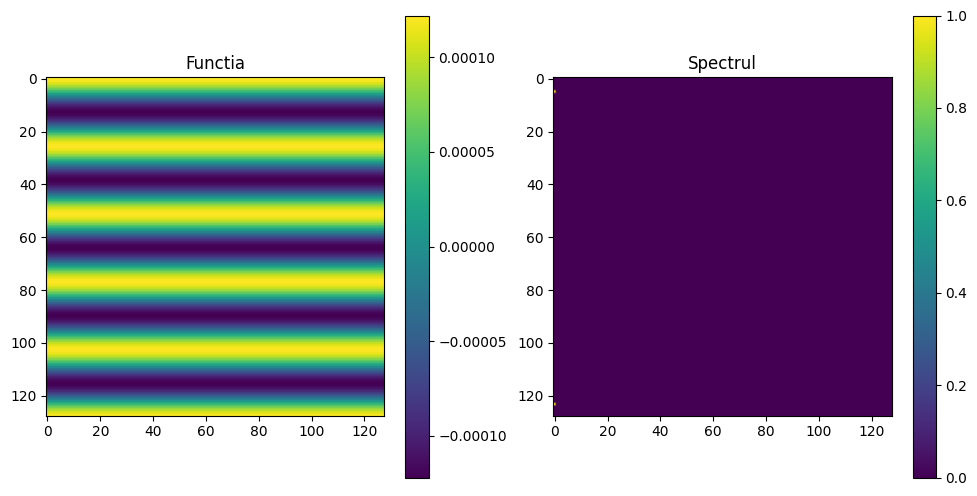

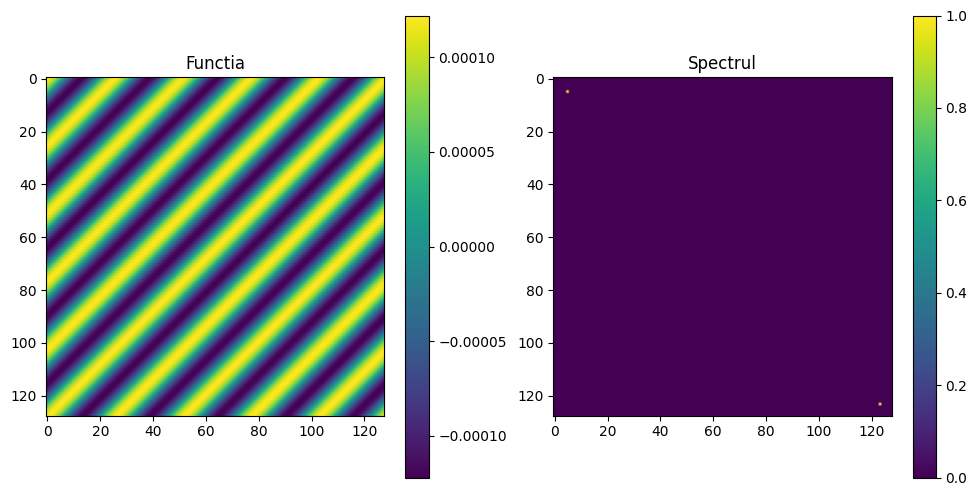

In [16]:
def create_from_spectrum(coords):
    Y = np.zeros((n1, n2))
    for coord in coords:
        Y[coord] = 1
    plot_image_and_spectrum(Y=Y)


create_from_spectrum([(0, 5), (0, -5)])
create_from_spectrum([(5, 0), (-5, 0)])
create_from_spectrum([(5, 5), (-5, -5)])

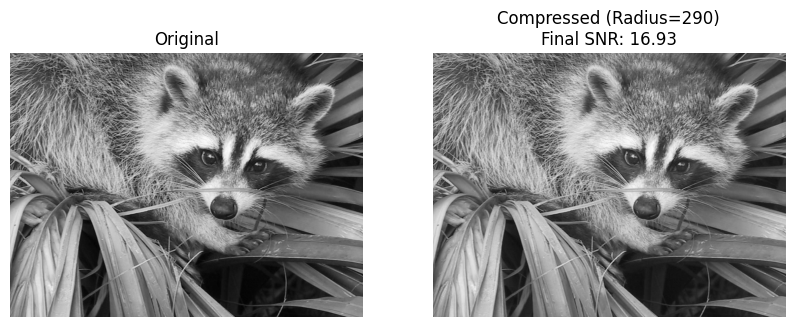

In [25]:
target_snr_threshold = 15.0 

def calculate_snr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0: return np.inf
    return np.mean(original**2) / mse

rows, cols = X.shape
crow, ccol = rows // 2, cols // 2
Y = np.fft.fftshift(np.fft.fft2(X))

y_grid, x_grid = np.ogrid[:rows, :cols]
dist_from_center = np.sqrt((x_grid - ccol)**2 + (y_grid - crow)**2)

compressed_image = X.copy()
final_radius = 0
final_snr = 0

for radius in range(400, 10, -10):
    mask = dist_from_center <= radius
    
    Y_masked = Y * mask
    X_reconstructed = np.real(np.fft.ifft2(np.fft.ifftshift(Y_masked)))
    
    current_snr = calculate_snr(X, X_reconstructed)
    
    if current_snr < target_snr_threshold:
        break
    
    compressed_image = X_reconstructed
    final_radius = radius
    final_snr = current_snr

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(X, cmap='gray')
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(compressed_image, cmap='gray')
axs[1].set_title(f"Compressed (Radius={final_radius})\nFinal SNR: {final_snr:.2f}")
axs[1].axis('off')
plt.show()

SNR Noisy: 0.01
SNR after Gaussian (Freq): 0.13
SNR after Median (Percentile): 0.03


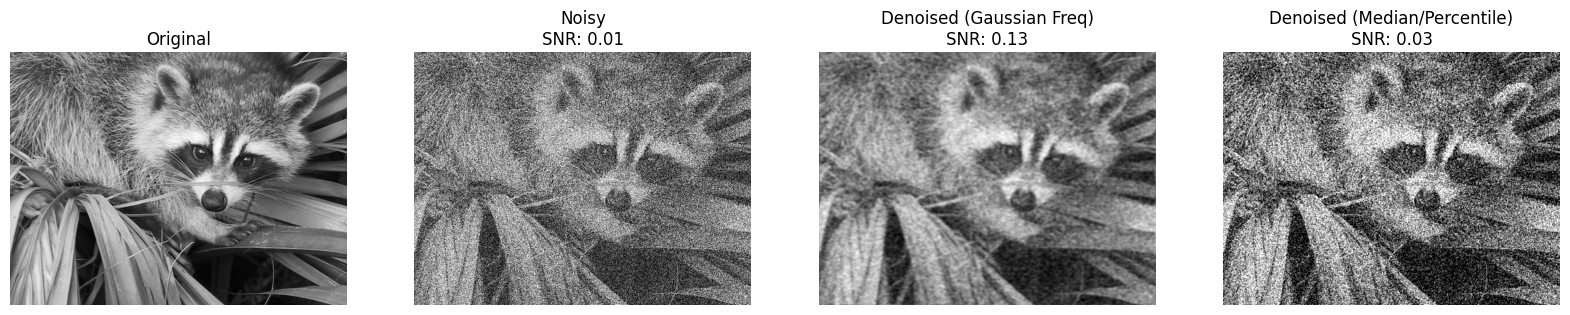

In [26]:
pixel_noise = 200
noise = np.random.randint(-pixel_noise, high=pixel_noise + 1, size=X.shape)
X_noisy = np.clip(X + noise, 0, 255)

def gaussian_filter_fast(shape, sigma):
    rows, cols = shape
    y = np.arange(rows) - rows // 2
    x = np.arange(cols) - cols // 2
    r2 = y[:, np.newaxis]**2 + x[np.newaxis, :]**2
    return np.exp(-r2 / (2 * sigma**2))

Y_noisy = np.fft.fftshift(np.fft.fft2(X_noisy))
kernel_gauss = gaussian_filter_fast(X.shape, sigma=50)
X_denoised_freq = np.real(np.fft.ifft2(np.fft.ifftshift(Y_noisy * kernel_gauss)))

X_denoised_median = ndimage.percentile_filter(X_noisy, percentile=50, size=3)

snr_noisy = calculate_snr(X, X_noisy)
snr_freq = calculate_snr(X, X_denoised_freq)
snr_median = calculate_snr(X, X_denoised_median)

print(f"SNR Noisy: {snr_noisy:.2f}")
print(f"SNR after Gaussian (Freq): {snr_freq:.2f}")
print(f"SNR after Median (Percentile): {snr_median:.2f}")

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(X, cmap='gray'), axs[0].set_title("Original"), axs[0].axis('off')
axs[1].imshow(X_noisy, cmap='gray'), axs[1].set_title(f"Noisy\nSNR: {snr_noisy:.2f}"), axs[1].axis('off')
axs[2].imshow(X_denoised_freq, cmap='gray'), axs[2].set_title(f"Denoised (Gaussian Freq)\nSNR: {snr_freq:.2f}"), axs[2].axis('off')
axs[3].imshow(X_denoised_median, cmap='gray'), axs[3].set_title(f"Denoised (Median/Percentile)\nSNR: {snr_median:.2f}"), axs[3].axis('off')

plt.show()

# Sarcini

1. Produceți imaginile și spectrul pentru funcțiile de mai jos și dați o explicație scurtă pentru fiecare rezultat.
* $x_{n_1,n_2} = \sin(2\pi n_1 + 3\pi n_2)$
* $x_{n_1,n_2} = \sin(4\pi n_1) + \cos(6\pi n_2)$
* $Y_{0,5} = Y_{0,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
* $Y_{5,0} = Y_{N-5,0} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$
* $Y_{5,5} = Y_{N-5,N-5} = 1\text{, altfel }Y_{m_1,m_2} = 0,\ \forall m_1, m_2$

*Atenție*: $x$ reprezintă informație în domeniul timpului, $Y$ în domeninul frecvenței.

2. Comprimați imaginea cu ratonul de mai sus prin atenuarea frecvențelor înalte până la un prag SNR autoimpus.

3. Eliminați zgomotul adăugat la imaginea cu ratonul produsă mai sus. Prezentați raportul SNR înainte și după.